In [10]:
from models import Model
from utils import DATA_LOADER
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

In [15]:
if __name__ == "__main__":
    df = pd.read_csv("swmm_demo3_temp_results.csv",sep=",",skiprows=2, on_bad_lines='skip',header=None)
    w = np.array(df.iloc[:,4])*100 # water level in basin
    g = np.array(df.iloc[:,6])[:,None]
    g_a = np.array_split(g, len(w)) #split the gauge values into the same number of water levels  
    g_a = np.asarray([np.sum(gg,axis=0) for gg in g_a])# sum gauges values within each time slots 
    data_loader = DATA_LOADER(g_a,w,samp_rate=6,feat_type="hist_indiv",hist_step=6,time_delay=0)
    data_loader.get_feats_()
    # select a time slot for simulation
    idx_start = 100
    STEP = 15 # prediction steps, step = 30 min.
    idx_end = np.random.randint(idx_start,200)
    g_test, w_test = data_loader.get_batches_(idx_start=idx_start,idx_end=idx_end,step=STEP)

    g_temp1 = data_loader.get_feat_([0]*7)
    g_temp2 = data_loader.get_feat_([1]*7)
    g_temp = torch.stack((g_temp1,g_temp2))
    g_temp3 = data_loader.get_feat_([[2]*7])
    g_temp = torch.cat((g_temp,g_temp3),0)
    y0 = w_test[0] # initial value, cm
    MC_NUM =10 # num of Monte carlo simulation
    path = "joint_swmm_hist_indiv.pt"
    model = Model(FEATURE_TYPE="hist_indiv",INPUT_DIM=7,MODEL_TYPE="joint",SOLVER="rk4",PATH=path)
    w_pred, w_std = model.predict_(y0,g_test,step=STEP,mc_num=MC_NUM) # output: predictions, std

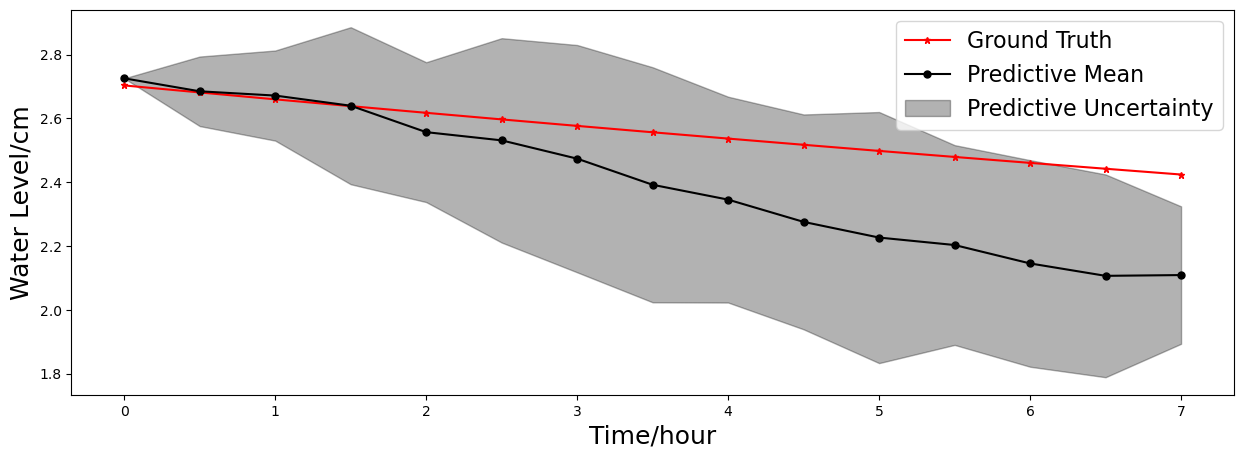

In [18]:
t = np.arange(0,7.5, .5)
#t = np.arange(w_pred.shape[0])
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(t,w_test,"r-*",linewidth=1.5,markersize=5,label="Ground Truth")
ax.plot(t,w_pred,"k-o",linewidth=1.5,markersize=5,label="Predictive Mean")
ax.fill_between(t,
     w_pred.ravel() - 1.96 * w_std.ravel(),
     w_pred.ravel() + 1.96 * w_std.ravel(),
     color='k',
     alpha=0.3,
     label='Predictive Uncertainty')
plt.xlabel('Time/hour', fontsize=18)
plt.ylabel('Water Level/cm', fontsize=18)
plt.legend(fontsize=16)